### Imports

In [203]:
import requests
import pandas as pd
import torch
from bs4 import BeautifulSoup
from tqdm import tqdm  # Import tqdm for the progress bar

from transformers import AutoTokenizer,AutoModelForSequenceClassification
import seaborn as sns

import re

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from scipy.special import softmax

import numpy as np
from sklearn.metrics import precision_score

### Scraping data

In [187]:

#pages = [20, 30, 40, 50, 60, 70, 80]
pages = list(range(20, 1600, 10))
reviews = []


for page in pages:
    # Construct the URL with the 'start' parameter
    url = f'https://www.yelp.com/biz/fogo-de-chão-brazilian-steakhouse-san-diego-3?start={page}'

    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    
    # getting comments
    regex = re.compile('.*comment.*')
    results = soup.find_all('p', {'class': regex})

    # getting stars
    regex_stars = re.compile('.*stars.*')
    ratings = soup.find_all('div', {'class': regex_stars})
    
    # Iterate elements to pair
    for result, rating in zip(results, ratings):
        rating_text = rating.get_text(strip=True)
        
        if re.match(r'^\d+(\.\d+)?$', rating_text):
            number = '0'

        else:
            aria_label = rating['aria-label']
            number = (aria_label.split()[0])

        # append
        reviews.append((result.text, number))
    

# 'reviews' now contains reviews from multiple pages
print(len(reviews), 'reviews scraped in total.')


1963 reviews scraped in total.


In [218]:
soup = BeautifulSoup(r.text, 'html.parser')
regex_date = re.compile(' css-chan6m')
dates = soup.find_all('span', {'class': regex_date})

In [220]:
da

<span class="fixed-size-text__09f24__bUCrM fixed-size-text--small__09f24__Bc2oE css-chan6m"><span class=""><span itemprop="reviewCount">2758</span></span></span>

In [188]:
# load reviews into dataframe and score it
df = pd.DataFrame(reviews, columns=['review', 'vote'])

for i in range(len(df)):
    if df.loc[i, 'vote'] == '(no':
        df.loc[i, 'vote'] = '0'
df['vote'] = df['vote'].astype(np.float64)

### Bert Multilingual Model

In [194]:
df_bert = df.copy()

In [195]:
# Instantiate the Model
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [196]:
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [197]:
df_bert['sentiment'] = df_bert['review'].apply( lambda x: sentiment_score(x[:512]))

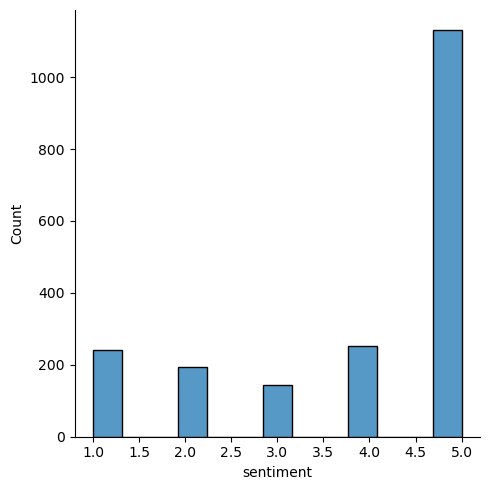

In [213]:
sns.displot(df_bert['sentiment']);

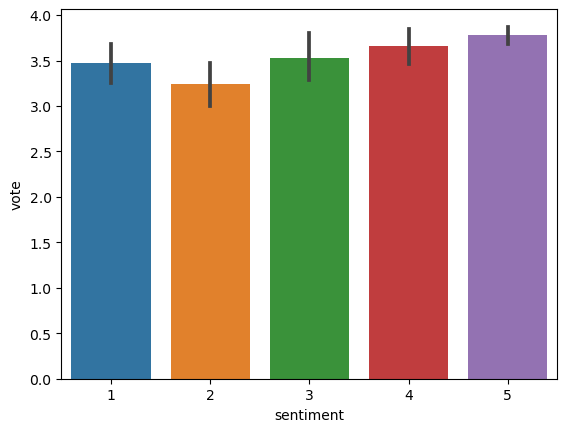

In [214]:
sns.barplot(x='sentiment', y='vote', data=df_bert);

In [222]:
df_bert.head(50)

,review,vote,sentiment
0,A truly mediocre meal. We went for Saturday b...,4.0,2
1,Serving exceptional meals is what we strive fo...,0.0,5
2,We found an amazing deal on instagram for a sp...,4.0,4
3,So we came downtown today to see a Filipino ar...,3.0,4
4,I had always heard of Fogo Dr Chão so I decide...,5.0,4
5,Fogo is a treat every few years. It's not wher...,4.0,4
6,Been coming to forgo de chao since they opened...,4.0,5
7,Always a great experience here every time I go...,4.0,5
8,Food is always good but the server David was o...,5.0,4
9,Mike the Chicken Guy was amazing!! His service...,5.0,5


In [211]:
actual_rating = np.array([4. , 3. , 5. , 1. , 2.])
predicted_sentiment = np.array([2, 5, 4, 1, 3])

threshold = 3.5

predicted_positive = (predicted_sentiment >= threshold).astype(int)

precision = precision_score(actual_rating >= threshold, predicted_positive)

In [212]:
precision

0.5

In [208]:
df_bert['vote'].unique()

array([4. , 0. , 3. , 5. , 1. , 4.5, 2. ])

In [209]:
df_bert['sentiment'].unique()

array([2, 5, 4, 1, 3])

### VADER Model

In [ ]:
df_vader = df.copy().reset_index()

In [ ]:
df_vader.head()

In [ ]:
# Initate the model
sia = SentimentIntensityAnalyzer()
res = {}

for i, row in tqdm(df_vader.iterrows(), total=len(df_vader)):
    text = row['review']
    my_id = row['index']
    res[my_id] = sia.polarity_scores(text)

In [ ]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index()
vader = vaders.merge(df_vader, how='left')

In [ ]:
vader.head()

### Compare both models

In [ ]:
df_bert = df_bert.reset_index()

In [ ]:
df_bert.head()

In [ ]:
vader.head()

In [ ]:
df_final = vader.merge(df_bert, how='inner')

In [ ]:
df_final.head()

In [ ]:
df_final.iloc[2]['review']